In [1]:
import networkx as nx
import pandas as pd
import numpy as np

import random
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

Leandro Stival<br>
RA: 263013

In [2]:
def nodes_with_degree(G, target_degree):
    '''
    Return the list of nodes that have degree equal than target_degree
    '''
    nodes = [node for node,degree in dict(G.degree()).items() if degree == target_degree]
    
    return nodes

In [3]:
def nodes_with_degree_less(G, target_degree):
    '''
    Return the list of nodes that have degree less than target_degree
    '''
    nodes = [node for node,degree in dict(G.degree()).items() if degree < target_degree]
    
    return nodes

In [4]:
def create_edge(G, node_1, node_2):
    '''
    This function avoid to create self links and multi links
    between the nodes node_1 and node_2 in the graph G.
    '''
    if (node_1 != node_2) and not(G.has_edge(node_1, node_2)):
        G.add_edge(node_1, node_2)

In [5]:
def initialize_graph():
    '''
    Create the graph and set the nodes according the number
    informed in N.
    '''
    G = nx.Graph()
    G.add_nodes_from(np.arange(N))
    
    return G

In [6]:
def connect_hub(G, hub):
    #Loop to create links to hub while they dont have the 
    #wanted degree.
    while G.degree(hub) < max_degree:
        available_nodes = nodes_with_degree_less(G, other_degree)
        
        #Remove hub of the possible neighbors to avoid self links
        if hub in available_nodes:
            available_nodes.remove(hub)
            
        #Shuffle the possible neighbors to set more
        #randomness in the results.
        random.shuffle(available_nodes)
        node_1 = random.choice(available_nodes)
        create_edge(G, hub, node_1)
    return G

In [7]:
def create_graph():
    #Define how node are the hub (get the max number of nodes)
    hub = random.randrange(N)
    G = initialize_graph()
    G = connect_hub(G, hub)

    #Counter to avoid looping in (ingraphical random choices)
    internal_count=0
    
    #Loop to create links while the total of node with degree
    #(other_degree) is N-1.

    while Counter(dict(G.degree()).values())[other_degree] < N-1:
        
        #List of node that can recive a new link
        available_nodes = nodes_with_degree_less(G, other_degree)
        random.shuffle(available_nodes)

        #Select a available node randomly
        node_1 = random.choice(available_nodes)
        #Remove the selected node from the options
        #to avoid that it be selected again.
        available_nodes.remove(node_1)

        try:
            #Try select a node to create a link
            random.shuffle(available_nodes)
            node_2 = random.choice(available_nodes)
            #Create a link between the nodes
            create_edge(G, node_1, node_2)
            
        except IndexError:
            #If dont have nodes avalible to connect
            #(generaly because the last nodes
            #already have links among us).
            #The network are reseted, and
            #links are chosen again.
            internal_count=0
            G = initialize_graph()
            G = connect_hub(G, hub)

        if internal_count == N*2:
            #If the network stay in infinte loop
            #because dont existe solutions for
            #the edges created, the links are
            #reseted.
            internal_count=0
            G = initialize_graph()
            G = connect_hub(G, hub)

        internal_count+=1  
        
    return G

### Doing the example <br>
With $100$ nodes where one node have degree $89$ and the others with $3$ degree.

In [8]:
N = 100
max_degree = 89
other_degree = 3

In [9]:
G = create_graph()
print(f'Degrees in the network: {Counter(dict(G.degree()).values())}')

Degrees in the network: Counter({3: 99, 89: 1})


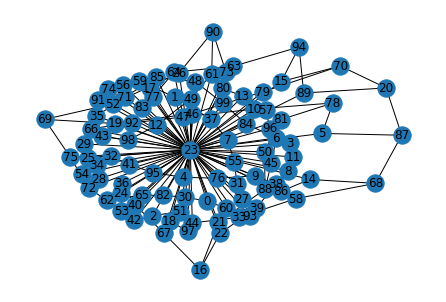

In [10]:
nx.draw(G, with_labels=True)

In [11]:
G.remove_node(max(nx.clustering(G, dict(G.degree())), key=dict(G.degree()).get))

In [12]:
print('After remove the node with biger degree, the network have:',
      len(list(nx.connected_components(G))),'component(s)')

After remove the node with biger degree, the network have: 1 component(s)


### Testing the robustness

Was tested $1000$ random seed (to create differente networks) and each network was attacked until breaking the giant component.

In [13]:
def hub_attack(G):
    #Get the node with biger degree
    max_degree_index = max(nx.clustering(G, dict(G.degree())), key=dict(G.degree()).get)
    
    #Get the degree of biggest node
    max_degree = G.degree(max_degree_index)
    
    #Define the list of node with degree equal max degree
    list_node_with_max_degree = nodes_with_degree(G, max_degree)
    
    #Testing all node to see how can be removed and dont disconect the network
    for node in list_node_with_max_degree:
        G2 = G.copy()
        G2.remove_node(node)
        #If removing the node and keeping the network connected
        #return the network without the node
        if len(list(nx.connected_components(G))) == 1:
            return G2, True
    
    return G, False

In [14]:
N=100
number_of_seeds = 100

In [15]:
dict_results = {}

for sequential_seed in tqdm(range(number_of_seeds)):
    
    random.seed(sequential_seed)

    G = create_graph()

    keeping_attacking = True
    received_attacks=0
    
    while keeping_attacking:
        G, keeping_attacking = hub_attack(G)
        received_attacks+=1

    dict_results[sequential_seed] = received_attacks-1

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.96it/s]


In [16]:
print('The maximum attacks that the network resisted was:',
     max(dict_results.values()))

The maximum attacks that the network resisted was: 5


The network keep the giant component in the first attackes, but conforme more nodes are removed the network it is fragmenting. <br>
This results shows that achictecture (create the firsts links connecting the hub to other nodes, until it is with the desired degree) can create robust network to the first attacks. However, as attacks continue, the network loses the behaviour. <br>